In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_mcc'
metric_filter_2 = 'val_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.07, 0.03, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [len(dataset_val.node_attributes)] * 2],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 24/24 [01:05<00:00,  2.74s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 264/264 [00:13<00:00, 20.11it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.5479242,
 'train_acc': 0.48571425676345825,
 'val_acc': 0.44444432854652405,
 'epoch': 20,
 'model_class': 'fnn',
 'path_name': '4_[10_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_20',
 'train_rmse': 0.828078671210825,
 'val_rmse': 1.0954451150103321,
 'test_rmse': 1.0081152197523338,
 'train_rmse_perc': 0.20851497,
 'val_rmse_perc': 0.2763692,
 'test_rmse_perc': 0.24368563,
 'train_mcc': 0.3051030615148965,
 'val_mcc': 0.23097195246903487,
 'test_mcc': 0.2888650790834174,
 'test_acc': 0.4525925815105438}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.7047917,
 'train_acc': 0.4476190209388733,
 'val_acc': 0.4222221076488495,
 'epoch': 80,
 'model_class': 'fnn',
 'path_name': '4_[10_15]_4_ReLU()_None_0.2_0.1_adamw_max_val_mcc_False_mse_False_0_80',
 'train_rmse': 0.8338093878327919,
 'val_rmse': 1.0540925533894598,
 'test_rmse': 0.9071730611977865,
 'train_rmse_perc': 0.2290881,
 'val_rmse_perc': 0.2832718,
 'test_rmse_perc': 0.23170336,
 'train_mcc': 0.32864694893805035,
 'val_mcc': 0.223918312757173,
 'test_mcc': 0.32512921142122125,
 'test_acc': 0.4148148000240326}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.7519978,
 'train_acc': 0.39047616720199585,
 'val_acc': 0.4666665494441986,
 'epoch': 30,
 'model_class': 'fnn',
 'path_name': '4_[10_15]_4_ReLU()_gn_0.2_0.1_adamw_max_val_mcc_False_mse_False_0_30',
 'train_rmse': 0.8338093878327919,
 'val_rmse': 1.0954451150103321,
 'test_rmse': 0.9790395898626973,
 'train_rmse_perc': 0.21490575,
 'val_rmse_perc': 0.26732048,
 'test_rmse_perc': 0.24634488,
 'train_mcc': 0.18986557609449256,
 'val_mcc': 0.3838327250665648,
 'test_mcc': 0.2171978538308696,
 'test_acc': 0.36592593789100647}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 264/264 [00:00<00:00, 24064.86it/s]


### GCN

In [14]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [15]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [06:45<00:00,  5.63s/it]


#### Results

In [16]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [00:48<00:00, 16.40it/s]


In [17]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.74752784,
 'train_acc': 0.40952378511428833,
 'val_acc': 0.3111110329627991,
 'epoch': 30,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_True_mse_True_0.2_30',
 'train_rmse': 0.9360504666899516,
 'val_rmse': 1.2823589374447564,
 'test_rmse': 0.9063561559792495,
 'train_rmse_perc': 0.24060929,
 'val_rmse_perc': 0.35304755,
 'test_rmse_perc': 0.24076091,
 'train_mcc': 0.29377525400691096,
 'val_mcc': 0.07394793914329262,
 'test_mcc': 0.3320075479216822,
 'test_acc': 0.44370371103286743}

In [18]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.78913975,
 'train_acc': 0.39047616720199585,
 'val_acc': 0.37777769565582275,
 'epoch': 99,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0.2',
 'train_rmse': 0.9461702252967461,
 'val_rmse': 1.0749676997731399,
 'test_rmse': 0.8886110676947647,
 'train_rmse_perc': 0.23635091,
 'val_rmse_perc': 0.27917218,
 'test_rmse_perc': 0.21720244,
 'train_mcc': 0.30060945800869554,
 'val_mcc': 0.15543832804525193,
 'test_mcc': 0.3447095470319685,
 'test_acc': 0.4333333373069763}

In [19]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.0520676,
 'train_acc': 0.4285714030265808,
 'val_acc': 0.4222221076488495,
 'epoch': 10,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0.2_10',
 'train_rmse': 0.9952267030562386,
 'val_rmse': 1.1155467020454342,
 'test_rmse': 1.0488088481701516,
 'train_rmse_perc': 0.2726627,
 'val_rmse_perc': 0.2901292,
 'test_rmse_perc': 0.27477026,
 'train_mcc': 0.24985040350696497,
 'val_mcc': 0.2783638805539702,
 'test_mcc': 0.2184061506340115,
 'test_acc': 0.402222216129303}

In [20]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 30544.42it/s]


### GraphSAGE

In [21]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [22]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 168/168 [3:05:52<00:00, 66.39s/it]  


#### Results

In [23]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1386/1386 [07:58<00:00,  2.90it/s]


True

In [24]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.087658465,
 'train_acc': 0.6380952000617981,
 'val_acc': 0.7111109495162964,
 'epoch': 80,
 'model_class': 'sage',
 'path_name': '4_[30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_80',
 'train_rmse': 0.7988086367179802,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.6194382162118379,
 'train_rmse_perc': 0.18398976,
 'val_rmse_perc': 0.13807438,
 'test_rmse_perc': 0.14336288,
 'train_mcc': 0.5248961500049361,
 'val_mcc': 0.6160268319752573,
 'test_mcc': 0.6555090247640487,
 'test_acc': 0.7400000095367432}

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.087658465,
 'train_acc': 0.6380952000617981,
 'val_acc': 0.7111109495162964,
 'epoch': 80,
 'model_class': 'sage',
 'path_name': '4_[30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_80',
 'train_rmse': 0.7988086367179802,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.6194382162118379,
 'train_rmse_perc': 0.18398976,
 'val_rmse_perc': 0.13807438,
 'test_rmse_perc': 0.14336288,
 'train_mcc': 0.5248961500049361,
 'val_mcc': 0.6160268319752573,
 'test_mcc': 0.6555090247640487,
 'test_acc': 0.7400000095367432}

In [26]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.3847801,
 'train_acc': 0.6190475821495056,
 'val_acc': 0.7777775526046753,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0.2_60',
 'train_rmse': 0.7745966692414834,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.7200822998230956,
 'train_rmse_perc': 0.17440139,
 'val_rmse_perc': 0.15619987,
 'test_rmse_perc': 0.16268875,
 'train_mcc': 0.5029673973410929,
 'val_mcc': 0.7167487349599454,
 'test_mcc': 0.5728164435372629,
 'test_acc': 0.6762962937355042}

In [27]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1386/1386 [00:00<00:00, 29569.50it/s]


#### cm

In [28]:
cm = all[sort_idx[0]]['test_cm'][0]

In [29]:
(cm.labels==0).sum()

tensor(351)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

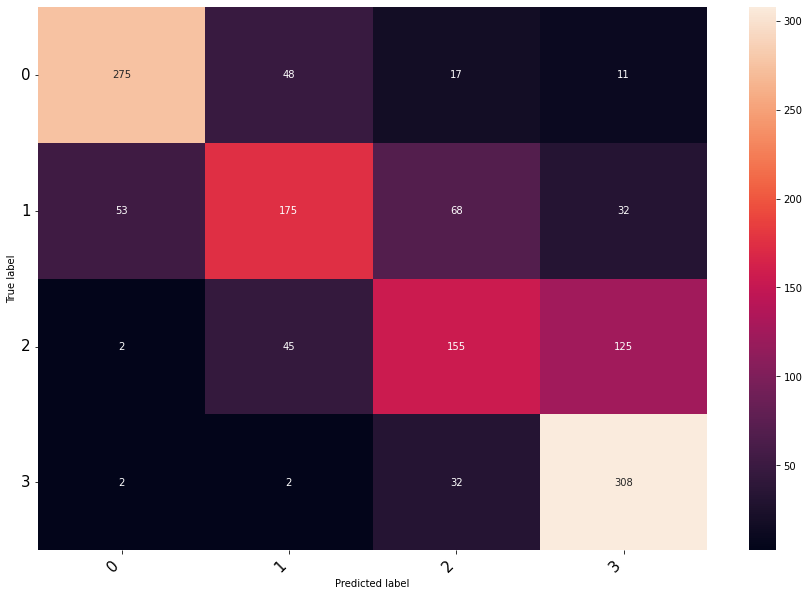

In [30]:
cm.visualize()

In [31]:
cm.class_accuracy

tensor([0.7835, 0.5335, 0.4740, 0.8953])

In [32]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.17597763, 0.1909882, 0.14250371, 0.13486327]

In [34]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.10359016, 0.14085221, 0.11275216, 0.09126493]

#### GraphSAGE Base_n

In [35]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [36]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

100%|██████████| 336/336 [3:19:38<00:00, 35.65s/it]  


##### Results

In [37]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 2772/2772 [08:51<00:00,  5.22it/s]


True

In [38]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.43415478,
 'train_acc': 0.5714285373687744,
 'val_acc': 0.3999998867511749,
 'epoch': 30,
 'model_class': 'sage',
 'path_name': '4_[30]_1_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_True_0.2_30',
 'train_rmse': 0.6761234037828132,
 'val_rmse': 0.7745966692414834,
 'test_rmse': 0.7403702777314526,
 'train_rmse_perc': 0.18432437,
 'val_rmse_perc': 0.20603727,
 'test_rmse_perc': 0.18960117,
 'train_mcc': 0.47494855953693155,
 'val_mcc': 0.3441393239046015,
 'test_mcc': 0.423669224109029,
 'test_acc': 0.5370370149612427}

In [39]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.43415478,
 'train_acc': 0.5714285373687744,
 'val_acc': 0.3999998867511749,
 'epoch': 30,
 'model_class': 'sage',
 'path_name': '4_[30]_1_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_True_0.2_30',
 'train_rmse': 0.6761234037828132,
 'val_rmse': 0.7745966692414834,
 'test_rmse': 0.7403702777314526,
 'train_rmse_perc': 0.18432437,
 'val_rmse_perc': 0.20603727,
 'test_rmse_perc': 0.18960117,
 'train_mcc': 0.47494855953693155,
 'val_mcc': 0.3441393239046015,
 'test_mcc': 0.423669224109029,
 'test_acc': 0.5370370149612427}

In [40]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'mean',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.23273192,
 'train_acc': 0.6190475821495056,
 'val_acc': 0.577777624130249,
 'epoch': 80,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_mean_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_80',
 'train_rmse': 0.6969320524371696,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.7610908350908315,
 'train_rmse_perc': 0.191524,
 'val_rmse_perc': 0.19178928,
 'test_rmse_perc': 0.190649,
 'train_mcc': 0.49622643732044286,
 'val_mcc': 0.5198495044910963,
 'test_mcc': 0.37171731576748507,
 'test_acc': 0.5222222208976746}

In [41]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2772/2772 [00:00<00:00, 30882.17it/s]


##### cm

In [42]:
cm = all[sort_idx[0]]['test_cm'][0]

In [43]:
(cm.labels==0).sum()

tensor(334)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

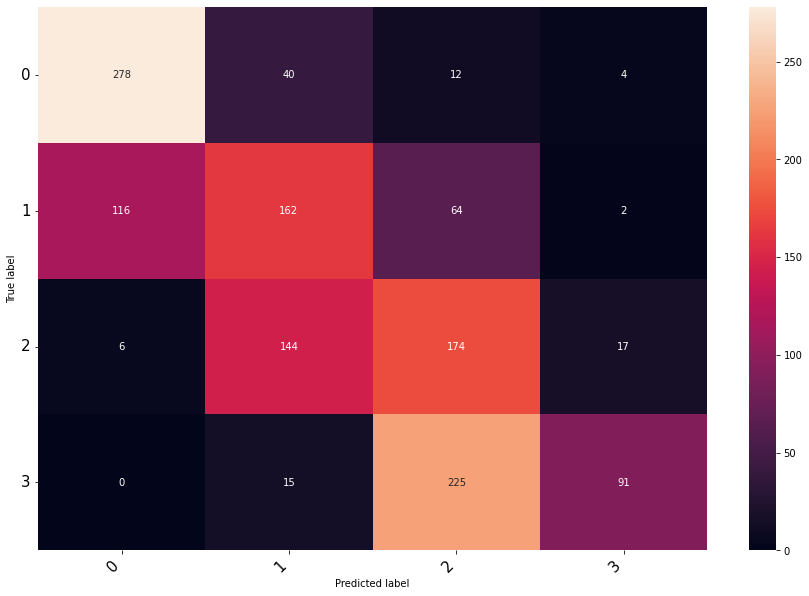

In [44]:
cm.visualize()

In [45]:
cm.class_accuracy

tensor([0.8323, 0.4709, 0.5103, 0.2749])

In [46]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.16944426, 0.17753647, 0.16172728, 0.24406683]

In [47]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.12566547, 0.14674291, 0.13903818, 0.2246747]

### GAT

In [48]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [49]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 576/576 [58:15<00:00,  6.07s/it]  


#### Results

In [50]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 6336/6336 [05:19<00:00, 19.84it/s]


In [51]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.97702074,
 'train_acc': 0.46666663885116577,
 'val_acc': 0.5111109614372253,
 'epoch': 99,
 'model_class': 'gat',
 'path_name': '4_[25_25]_1_[4_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_True_0.2',
 'train_rmse': 0.9154754164341269,
 'val_rmse': 1.0852547064066471,
 'test_rmse': 0.9209495904489823,
 'train_rmse_perc': 0.20804062,
 'val_rmse_perc': 0.22846742,
 'test_rmse_perc': 0.21514937,
 'train_mcc': 0.2856185651989043,
 'val_mcc': 0.3503338915113102,
 'test_mcc': 0.37742964573379933,
 'test_acc': 0.5303703546524048}

In [52]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.97702074,
 'train_acc': 0.46666663885116577,
 'val_acc': 0.5111109614372253,
 'epoch': 99,
 'model_class': 'gat',
 'path_name': '4_[25_25]_1_[4_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_True_0.2',
 'train_rmse': 0.9154754164341269,
 'val_rmse': 1.0852547064066471,
 'test_rmse': 0.9209495904489823,
 'train_rmse_perc': 0.20804062,
 'val_rmse_perc': 0.22846742,
 'test_rmse_perc': 0.21514937,
 'train_mcc': 0.2856185651989043,
 'val_mcc': 0.3503338915113102,
 'test_mcc': 0.37742964573379933,
 'test_acc': 0.5303703546524048}

In [53]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.7337897,
 'train_acc': 0.48571425676345825,
 'val_acc': 0.6888887286186218,
 'epoch': 80,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_True_0_80',
 'train_rmse': 0.9206622874969125,
 'val_rmse': 0.8944271909999159,
 'test_rmse': 0.9140872800534726,
 'train_rmse_perc': 0.20868236,
 'val_rmse_perc': 0.20400171,
 'test_rmse_perc': 0.21421756,
 'train_mcc': 0.3188995172532371,
 'val_mcc': 0.5830586137936496,
 'test_mcc': 0.35277962146299047,
 'test_acc': 0.5133333206176758}

In [54]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 6336/6336 [00:00<00:00, 28110.42it/s]
